#**Сборный проект 2 модуль**
# **МО - Золото для компании "Цифры"**

## Постановка задачи

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.
**Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. **

В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.
Вам нужно:
* Подготовить данные;
* Провести исследовательский анализ данных;
* Построить и обучить модель.

## Описание данных

**Технологический процесс**
* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: * Xanthate, Sulphate, Depressant
* Xanthate **— ксантогенат (промотер, или активатор флотации);
* Sulphate — сульфат (на данном производстве сульфид натрия);
* Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

**Параметры этапов**
* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

## Наименование признаков

**Наименование признаков должно быть такое:**
[этап].[тип_параметра].[название_параметра]

**Пример:** rougher.input.feed_ag

**Возможные значения для блока [этап]:**
* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики

**Возможные значения для блока [тип_параметра]:**
* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики


#**Выполнение проекта**

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display
import warnings
warnings.simplefilter('ignore')

In [2]:
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import defaultdict
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

In [3]:
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


## Подготовка данных

###  Откройте файлы и изучите их



In [4]:
import os

path1_1 = "/content/drive/MyDrive/Colab Notebooks/gold_recovery_full_new.csv"
path1_2 = "/content/drive/MyDrive/Colab Notebooks/gold_recovery_train_new.csv"
path1_3 = "/content/drive/MyDrive/Colab Notebooks/gold_recovery_test_new.csv"

path2_1 = "/datasets/gold_recovery_full_new.csv"
path2_2 = "/datasets/gold_recovery_train_new.csv"
path2_3 = "/datasets/gold_recovery_test_new.csv"

if os.path.exists(path1_1):
    df_full = pd.read_csv(path1_1)  
    df_train = pd.read_csv(path1_2)
    df_test = pd.read_csv(path1_3)
elif os.path.exists(path2_1):
    df_full = pd.read_csv(path2_1)
    df_train = pd.read_csv(path2_2)
    df_test = pd.read_csv(path2_3)

In [5]:
def get_data_info(data):
    display(data.sample(5))
    display(data.info())
    display(data.describe(include='all'))

get_data_info(df_full)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
13730,2017-11-02 20:59:59,4.667467,11.180347,8.725633,45.517623,70.686389,7.902807,3.343519,14.172204,2.506429,...,19.956543,-500.674254,17.922203,-499.980414,13.991605,-500.391654,10.010983,-500.209311,14.004925,-499.979686
13348,2017-10-17 02:59:59,4.865482,10.951002,8.647920,44.854080,72.991929,6.051691,2.726308,14.821274,2.198738,...,18.009299,-500.252011,16.033452,-399.710378,12.979016,-500.037924,10.018994,-499.800441,13.997326,-500.171856
13962,2017-11-13 07:59:59,4.634674,9.226270,9.112564,46.652050,74.942735,10.358276,2.653054,12.215975,2.903969,...,17.003230,-500.722536,9.887272,-500.146930,10.900760,-499.833134,8.933381,-499.951987,15.985610,-502.362500
9412,2017-04-12 13:59:59,5.723294,11.297888,10.642940,42.814547,69.196357,8.775551,3.092309,12.321890,2.616266,...,24.993398,-399.629993,22.979462,-400.012922,25.983004,-450.317480,23.953989,-449.963459,30.007369,-500.378638
3557,2016-07-13 08:59:59,5.855802,10.931368,16.834612,42.835475,50.494423,9.060627,1.999829,11.622840,3.175689,...,15.015981,-400.674587,4.987453,-400.616051,9.994851,-300.880033,4.911405,-399.516576,25.002610,-451.292669


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


None

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19439,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
unique,19439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2017-06-22 16:59:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,NaN,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,NaN,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,NaN,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,NaN,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378


In [6]:
def get_data_info(data):
    display(data.sample(5))
    display(data.info())
    display(data.describe(include='all'))

get_data_info(df_train)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
9283,2017-08-10 13:59:59,4.075826,10.957556,6.729987,47.187943,66.809127,8.298221,3.941890,9.087722,2.806101,...,16.011088,-499.899356,11.937753,-399.925694,16.077107,-500.073676,11.989722,-499.959135,14.995282,-500.027298
3230,2016-06-24 04:59:59,5.282541,10.433919,8.487392,43.590236,66.645022,7.938640,1.728114,11.828182,2.714004,...,16.046910,-500.093480,7.866907,-496.587037,15.800194,-499.565883,7.029725,-500.150301,24.999453,-499.356693
7284,2017-05-03 10:59:59,4.942539,11.411613,8.406831,43.697498,67.284307,9.118465,3.475772,8.432516,2.991366,...,24.965914,-397.733163,22.997875,-399.599503,25.978311,-449.790627,23.827275,-450.107731,30.015613,-499.918329
4264,2016-08-13 21:59:59,5.142122,8.926614,10.914613,46.054538,72.935557,11.092265,2.633108,10.981289,3.255001,...,20.052758,-399.834966,10.132255,-399.896963,15.021828,-399.939481,5.001917,-399.945686,23.036697,-498.870065
1191,2016-03-11 08:00:00,1.288101,3.243331,2.906544,11.315601,86.359856,11.051069,1.627759,16.075885,3.111944,...,11.984981,-448.259923,11.928852,-449.507316,12.046329,-448.996459,9.982715,-449.792738,19.560363,-498.822925


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


None

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14149,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
unique,14149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2017-06-22 16:59:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,NaN,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,NaN,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,NaN,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,NaN,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466


In [7]:
def get_data_info(data):
    display(data.sample(5))
    display(data.info())
    display(data.describe(include='all'))

display(get_data_info(df_test))

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
4733,2017-12-06 09:59:59,204.756240,9.001591,6.60,1.708018,1546.968122,-500.769050,1549.090024,-504.408323,1552.407449,...,19.988744,-498.421104,15.087676,-138.181419,10.932797,-497.774142,8.971215,-499.356456,16.005006,-498.473885
542,2016-10-02 22:59:59,118.303157,3.257513,7.26,0.803684,1590.954215,-501.181929,1586.259907,-499.807535,1590.739234,...,12.015857,-499.645005,13.005289,-497.688567,10.053496,-501.186857,8.049834,-500.451069,22.986948,-500.835234
754,2016-10-12 11:59:59,182.173860,7.962209,8.14,0.699666,1502.122144,-499.376637,1499.885720,-499.171576,1500.513957,...,11.993122,-500.900364,11.945660,-499.170987,9.544858,-497.725088,8.061330,-499.841832,17.016753,-499.162686
662,2016-10-08 05:59:59,206.573992,6.019591,7.34,0.922563,1499.326250,-500.209669,1499.756479,-500.019020,1499.471210,...,11.985314,-498.819946,11.956175,-499.375250,10.375321,-497.493615,7.022727,-499.921171,17.991710,-496.841446
468,2016-09-29 13:59:59,16.223643,NaN,8.38,0.080215,1601.171129,-500.306888,1601.390223,-499.704200,1600.129669,...,11.980208,-499.337303,9.919378,-499.255251,10.007758,-656.574395,5.073701,-499.346188,19.985170,-499.977234


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

None

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5290,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
unique,5290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2017-11-01 05:59:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,NaN,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,NaN,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,NaN,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,NaN,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,NaN,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018


None

После первого знакомства с данными видим что: 

1. Полная выборка  19439 строк  и 86 показателей 
2. Тренировочная 14149 строк  и тоже 86 показателей 
3. Тестовая  5290 строк и всего 52 показателя. Не хватает 34 столбцов

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:  </b> 
    
С данными познакомились, проведен первичный аналитический осмотр!) Полученная информация поможет нам в дальнейшем с предобработкой данных.

### Проверьте, что эффективность обогащения рассчитана правильно.


#### Расчёт эффективности
Вам нужно смоделировать процесс восстановления золота из золотосодержащей руды. 
Эффективность обогащения рассчитывается по формуле где:
* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.

**Recovery = C * (F-T) * 100 / (F * (C-T))**

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.


Добавим столбец 'rougher.output.recovery_calculation' с расчетом эфективности  обогащения

In [8]:
C = df_train['rougher.output.concentrate_au']   #доля золота в концентрате после флотации/очистки;
F = df_train['rougher.input.feed_au']           #доля золота в сырье/концентрате до флотации/очистки;
T = df_train['rougher.output.tail_au']          #доля золота в отвальных хвостах после флотации/очистки.

df_train['rougher.output.recovery_calculation'] = C*(F-T)*100/(F*(C-T)) #добавим новый столбец

Сравним рассчитанную эффективность через describe с эффективностью обогащения имеющейся в датасете 'rougher.output.recovery'

столбец 'final.output.recovery' добавила для интереса чтоб сравнить 

Результаты идентичны, можно считать что эффективность обогащения  рассчитана верно

In [9]:
display(df_train[['rougher.output.recovery_calculation', 'rougher.output.recovery', 'final.output.recovery']].describe())

,rougher.output.recovery_calculation,rougher.output.recovery,final.output.recovery
count,14149.000000,14149.000000,14149.000000
mean,82.704502,82.704502,66.518832
std,14.479156,14.479156,10.295402
min,-0.000000,0.000000,0.000000
25%,79.993067,79.993067,62.545817
50%,85.299462,85.299462,67.432775
75%,90.165021,90.165021,72.346428
max,100.000000,100.000000,100.000000


### Найдите MAE между вашими расчётами и значением признака. Опишите выводы.



In [10]:
def mae_recovery (target, calculation):
    return abs(target - calculation).sum() / len(target)
    
print('Cредняя абсолютная разница  между фактическими и расчитанными значениями  recovery на этапе  "rougher.output" составляет:', 
      mae_recovery (df_train['rougher.output.recovery'], df_train['rougher.output.recovery_calculation']).round(2), '%'
      )

Cредняя абсолютная разница  между фактическими и расчитанными значениями  recovery на этапе  "rougher.output" составляет: 0.0 %


mae также показал почти  нулевое отклонение  расчитанного значения и данных в выборке.

Из-за ранее посмотренного describe это не удивляет, но ради интереса посмотри mae для рекавери на финальном этапе. 

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Твое расссчитанное значение `MAE` верно)

In [11]:
#ради интереса сравним со значениями в столбце 'final.output.recovery'
print('Cредняя абсолютная разница  между фактическими и расчитанными значениями  recovery   и recovery на этапе  "final.output" составляет:', 
      mae_recovery (df_train['final.output.recovery'], df_train['rougher.output.recovery_calculation']).round(2), '%'
      )

Cредняя абсолютная разница  между фактическими и расчитанными значениями  recovery   и recovery на этапе  "final.output" составляет: 19.22 %


при сравнении с рекавери на финальном этапе видим ожидаемое  отклонение в 19% 

### Проанализируйте признаки, недоступные в тестовой выборке.


Создадим список из столбцов  присутствующих в выборке full, но отсутствующий в выборке test 

Получили список из 34  искомых элементов.
Все  34 элемента содержат в названии output.

Возможно их нет в тестовой выборке потому что на момент "снятия данных" этих данных технологический процессы не завершены и выходные данные (output) разных стадий ещё не известны. 


<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b>  
    
В тестовой выборке недоступны некоторые расчетные (calculation) и выходные (output) характеристики процесса, ведь их невозможно получить либо замерить во время выполнения технологического процесса.

In [12]:
check_col = list(df_train.columns.difference(df_test.columns))

print(len(check_col))
print(*check_col, sep='\n')

35
final.output.concentrate_ag
final.output.concentrate_au
final.output.concentrate_pb
final.output.concentrate_sol
final.output.recovery
final.output.tail_ag
final.output.tail_au
final.output.tail_pb
final.output.tail_sol
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_au
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_au
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
rougher.calculation.au_pb_ratio
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.sulfate_to_au_concentrate
rougher.output.concentrate_ag
rougher.output.concentrate_au
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.recovery
rougher.output.recovery_calculation
rougher.output.tail_ag
rougher.output.tail_au
rougher.output.tail_pb
rougher.output.tail_sol
secondary_cleaner.output.tail_ag
secondary_cl

Cначала после обнаружения различающихся столбцов   я сразу их удалила, но без них не получилось выполннить  задание по анализу концентрации Au, Ag, Pb,

И чтобы не выполнять предобработку повторно я выполнила задание по анализу концентрации здесь. Да я понимаю что выполнять анализ до пред обработки не совсем хорошо, но так как в данном случае визуализацию делаем для сравнения данных в данных фулл и трейн, и на дальнейшее обучение моделей не повлияют то подумала что можно попробовать изменить порядок выполнения задач.  

#### Попробую выполнить задания по визуализации концентрации здесь, до удаления столбцов 

"Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы"

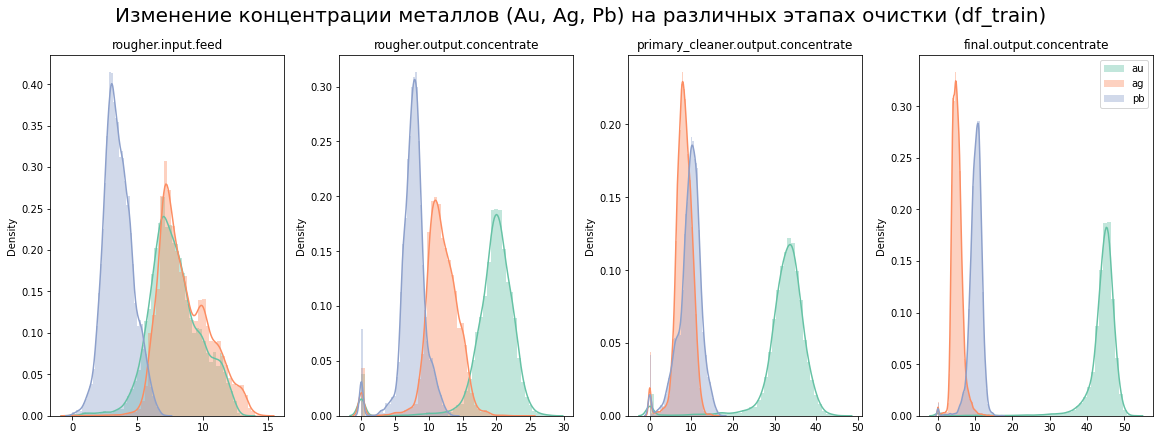

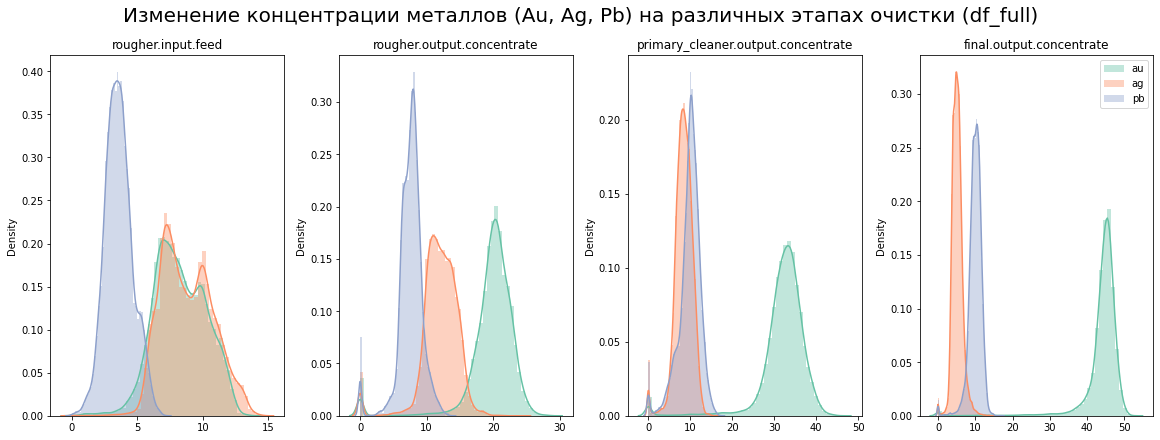

In [13]:
metals = ['au', 'ag', 'pb']
process = ['rougher.input.feed',
           'rougher.output.concentrate',
           'primary_cleaner.output.concentrate',
           'final.output.concentrate']

sns.set_palette('Set2') 

#концентрации на тренировочной выборке 
fig, axs = plt.subplots(1, len(process), figsize=(16, 6), constrained_layout=True)
fig.suptitle('Изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки (df_train)', fontsize=20)

for stage, ax in zip(process, axs):
    ax.set_title(stage)
    for metal in metals:        
        cols = df_train.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(df_train.loc[:, cols].dropna(), label=metal, ax=ax)    
plt.legend()

#концентрации на полной выборке 
fig, axs = plt.subplots(1, len(process), figsize=(16, 6), constrained_layout=True)
fig.suptitle('Изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки (df_full)', fontsize=20)

for stage, ax in zip(process, axs):
    ax.set_title(stage)
    for metal in metals:        
        cols = df_full.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(df_full.loc[:, cols].dropna(), label=metal, ax=ax)    
plt.legend()
plt.show()

#на тестовой выборке этих столбцов нет, поэтому не делаем


Собственно по графикам видим что визуально данные в фулл и трейн очень похожи,
А концентрация золота ожидаемо  растет по мере прохождения  по тех процессу 

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Верно!👍:\
</b> Мне интересно было изучить твои графики, практичный и красочный графический анализ. Видно, что золото растёт в концентрации - это здорово!) А серебро падает - ведь наша цель -  золото, верно?)
А свинец - это побочный элемент химических реакций, по этой причине немного и увеличивается его концентрация

#### Исследуйте суммарную концентрацию всех веществ на разных стадиях:
в сырье, в черновом и финальном концентратах


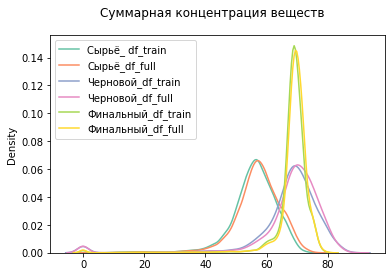

In [14]:
#datas = (df_train, df_full)
feed = ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol']
rougher = ['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol']
final = ['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol']

plt.suptitle('Суммарная концентрация веществ')

#в сырье 
sns.kdeplot(df_train[feed].sum(axis=1), label='Сырьё_ df_train')
sns.kdeplot(df_full[feed].sum(axis=1), label='Сырьё_df_full')

#в черновом концентрате 
sns.kdeplot(df_train[rougher].sum(axis=1), label='Черновой_df_train')
sns.kdeplot(df_full[rougher].sum(axis=1), label='Черновой_df_full')

#в финальном концентрате 
sns.kdeplot(df_train[final].sum(axis=1), label='Финальный_df_train')
sns.kdeplot(df_full[final].sum(axis=1), label='Финальный_df_full')

plt.legend()
plt.show()

#как сделать график покрупнее??? 

Видим что графики почти идентинтичны на полной и тренировочной выборке 

Удалим аномально маленькие значение:

In [15]:
df_train = df_train[
    (df_train[feed].sum(axis=1) > 10) & 
    (df_train[rougher].sum(axis=1) > 10) & 
    (df_train[final].sum(axis=1) > 10)
]

df_full = df_full[
    (df_full[feed].sum(axis=1) > 10) & 
    (df_full[rougher].sum(axis=1) > 10) & 
    (df_full[final].sum(axis=1) > 10)
]


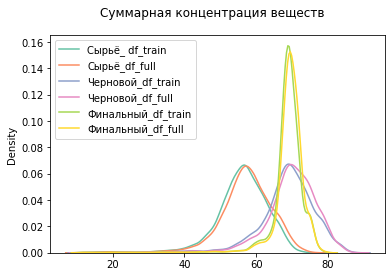

In [16]:
#datas = (df_train, df_full)
feed = ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol']
rougher = ['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol']
final = ['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol']

plt.suptitle('Суммарная концентрация веществ')

#в сырье 
sns.kdeplot(df_train[feed].sum(axis=1), label='Сырьё_ df_train')
sns.kdeplot(df_full[feed].sum(axis=1), label='Сырьё_df_full')

#в черновом концентрате 
sns.kdeplot(df_train[rougher].sum(axis=1), label='Черновой_df_train')
sns.kdeplot(df_full[rougher].sum(axis=1), label='Черновой_df_full')

#в финальном концентрате 
sns.kdeplot(df_train[final].sum(axis=1), label='Финальный_df_train')
sns.kdeplot(df_full[final].sum(axis=1), label='Финальный_df_full')

plt.legend()
plt.show()


#### И вот теперь наконец удалим лишние колонки 

In [17]:
check_col.remove('final.output.recovery')  #
check_col.remove('rougher.output.recovery')

print(len(check_col))
print(*check_col, sep='\n')

33
final.output.concentrate_ag
final.output.concentrate_au
final.output.concentrate_pb
final.output.concentrate_sol
final.output.tail_ag
final.output.tail_au
final.output.tail_pb
final.output.tail_sol
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_au
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_au
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
rougher.calculation.au_pb_ratio
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.sulfate_to_au_concentrate
rougher.output.concentrate_ag
rougher.output.concentrate_au
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.recovery_calculation
rougher.output.tail_ag
rougher.output.tail_au
rougher.output.tail_pb
rougher.output.tail_sol
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_au
secondary_cleaner.output.

In [18]:
df_train = df_train.drop(columns=check_col)
df_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 13781 entries, 0 to 14148
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        13781 non-null  object 
 1   final.output.recovery                       13781 non-null  float64
 2   primary_cleaner.input.sulfate               13763 non-null  float64
 3   primary_cleaner.input.depressant            13755 non-null  float64
 4   primary_cleaner.input.feed_size             13781 non-null  float64
 5   primary_cleaner.input.xanthate              13686 non-null  float64
 6   primary_cleaner.state.floatbank8_a_air      13777 non-null  float64
 7   primary_cleaner.state.floatbank8_a_level    13780 non-null  float64
 8   primary_cleaner.state.floatbank8_b_air      13777 non-null  float64
 9   primary_cleaner.state.floatbank8_b_level    13780 non-null  float64
 10  primary_cl

In [19]:
check_col.remove('rougher.output.recovery_calculation')
df_full = df_full.drop(columns=check_col)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13781 entries, 0 to 14148
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        13781 non-null  object 
 1   final.output.recovery                       13781 non-null  float64
 2   primary_cleaner.input.sulfate               13763 non-null  float64
 3   primary_cleaner.input.depressant            13755 non-null  float64
 4   primary_cleaner.input.feed_size             13781 non-null  float64
 5   primary_cleaner.input.xanthate              13686 non-null  float64
 6   primary_cleaner.state.floatbank8_a_air      13777 non-null  float64
 7   primary_cleaner.state.floatbank8_a_level    13780 non-null  float64
 8   primary_cleaner.state.floatbank8_b_air      13777 non-null  float64
 9   primary_cleaner.state.floatbank8_b_level    13780 non-null  float64
 10  primary_cl

In [20]:
df_full = df_full.set_index("date")
df_train = df_train.set_index("date")
df_test = df_test.set_index("date")

In [21]:
columns_add = ["final.output.recovery","rougher.output.recovery"]

df_test = df_test.join(df_full[columns_add])
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 non-null

### Проведите предобработку данных

#### Поиск и обработка пропусков 

Проверим есть ли пропуски. Мы конечно видели их уже при первом просмотре файла, но посчитаем.


Видим, что в тестовой выборке пропусков на порядок меньше ( возможно большинство пропусков живут в столбцах "output" которых нет в тестовой выборке.

In [22]:
for data in (df_full, df_train, df_test):
    print("Количество пропусков:", data.isna().sum().sum())

Количество пропусков: 1630
Количество пропусков: 1566
Количество пропусков: 368


In [23]:
def show_isna (data):
    nan = (data.isna() | data.isnull()).sum()
    res = (pd.concat([nan / data.shape[0], nan], axis=1,  keys=['%', 'abs'])
           .sort_values('%', ascending=False))
    return res


In [24]:
show_isna(df_full).head(5)

,%,abs
rougher.input.floatbank11_xanthate,0.021762,412
rougher.state.floatbank10_e_air,0.019702,373
secondary_cleaner.state.floatbank2_a_air,0.011409,216
rougher.input.feed_size,0.007395,140
rougher.input.feed_pb,0.005229,99


In [25]:
show_isna(df_train).head(5)

,%,abs
rougher.input.floatbank11_xanthate,0.028590,394
rougher.state.floatbank10_e_air,0.027066,373
secondary_cleaner.state.floatbank2_a_air,0.015456,213
rougher.input.feed_size,0.010086,139
rougher.input.feed_pb,0.007184,99


In [26]:
display(df_train[['rougher.state.floatbank10_e_air', 'rougher.input.floatbank11_xanthate', 'secondary_cleaner.state.floatbank2_a_air', 'rougher.input.feed_size']].describe())

,rougher.state.floatbank10_e_air,rougher.input.floatbank11_xanthate,secondary_cleaner.state.floatbank2_a_air,rougher.input.feed_size
count,13408.000000,13387.000000,13568.000000,13642.000000
mean,1091.428069,5.913396,29.662724,60.117816
std,185.172260,1.114903,5.780630,22.487121
min,-1.970275,0.000290,0.077503,9.659576
25%,997.223630,5.199841,25.105525,48.998810
50%,1050.618396,5.998876,30.031780,55.424801
75%,1200.100365,6.701044,34.898869,65.975687
max,1922.636637,9.698407,52.651399,484.967466


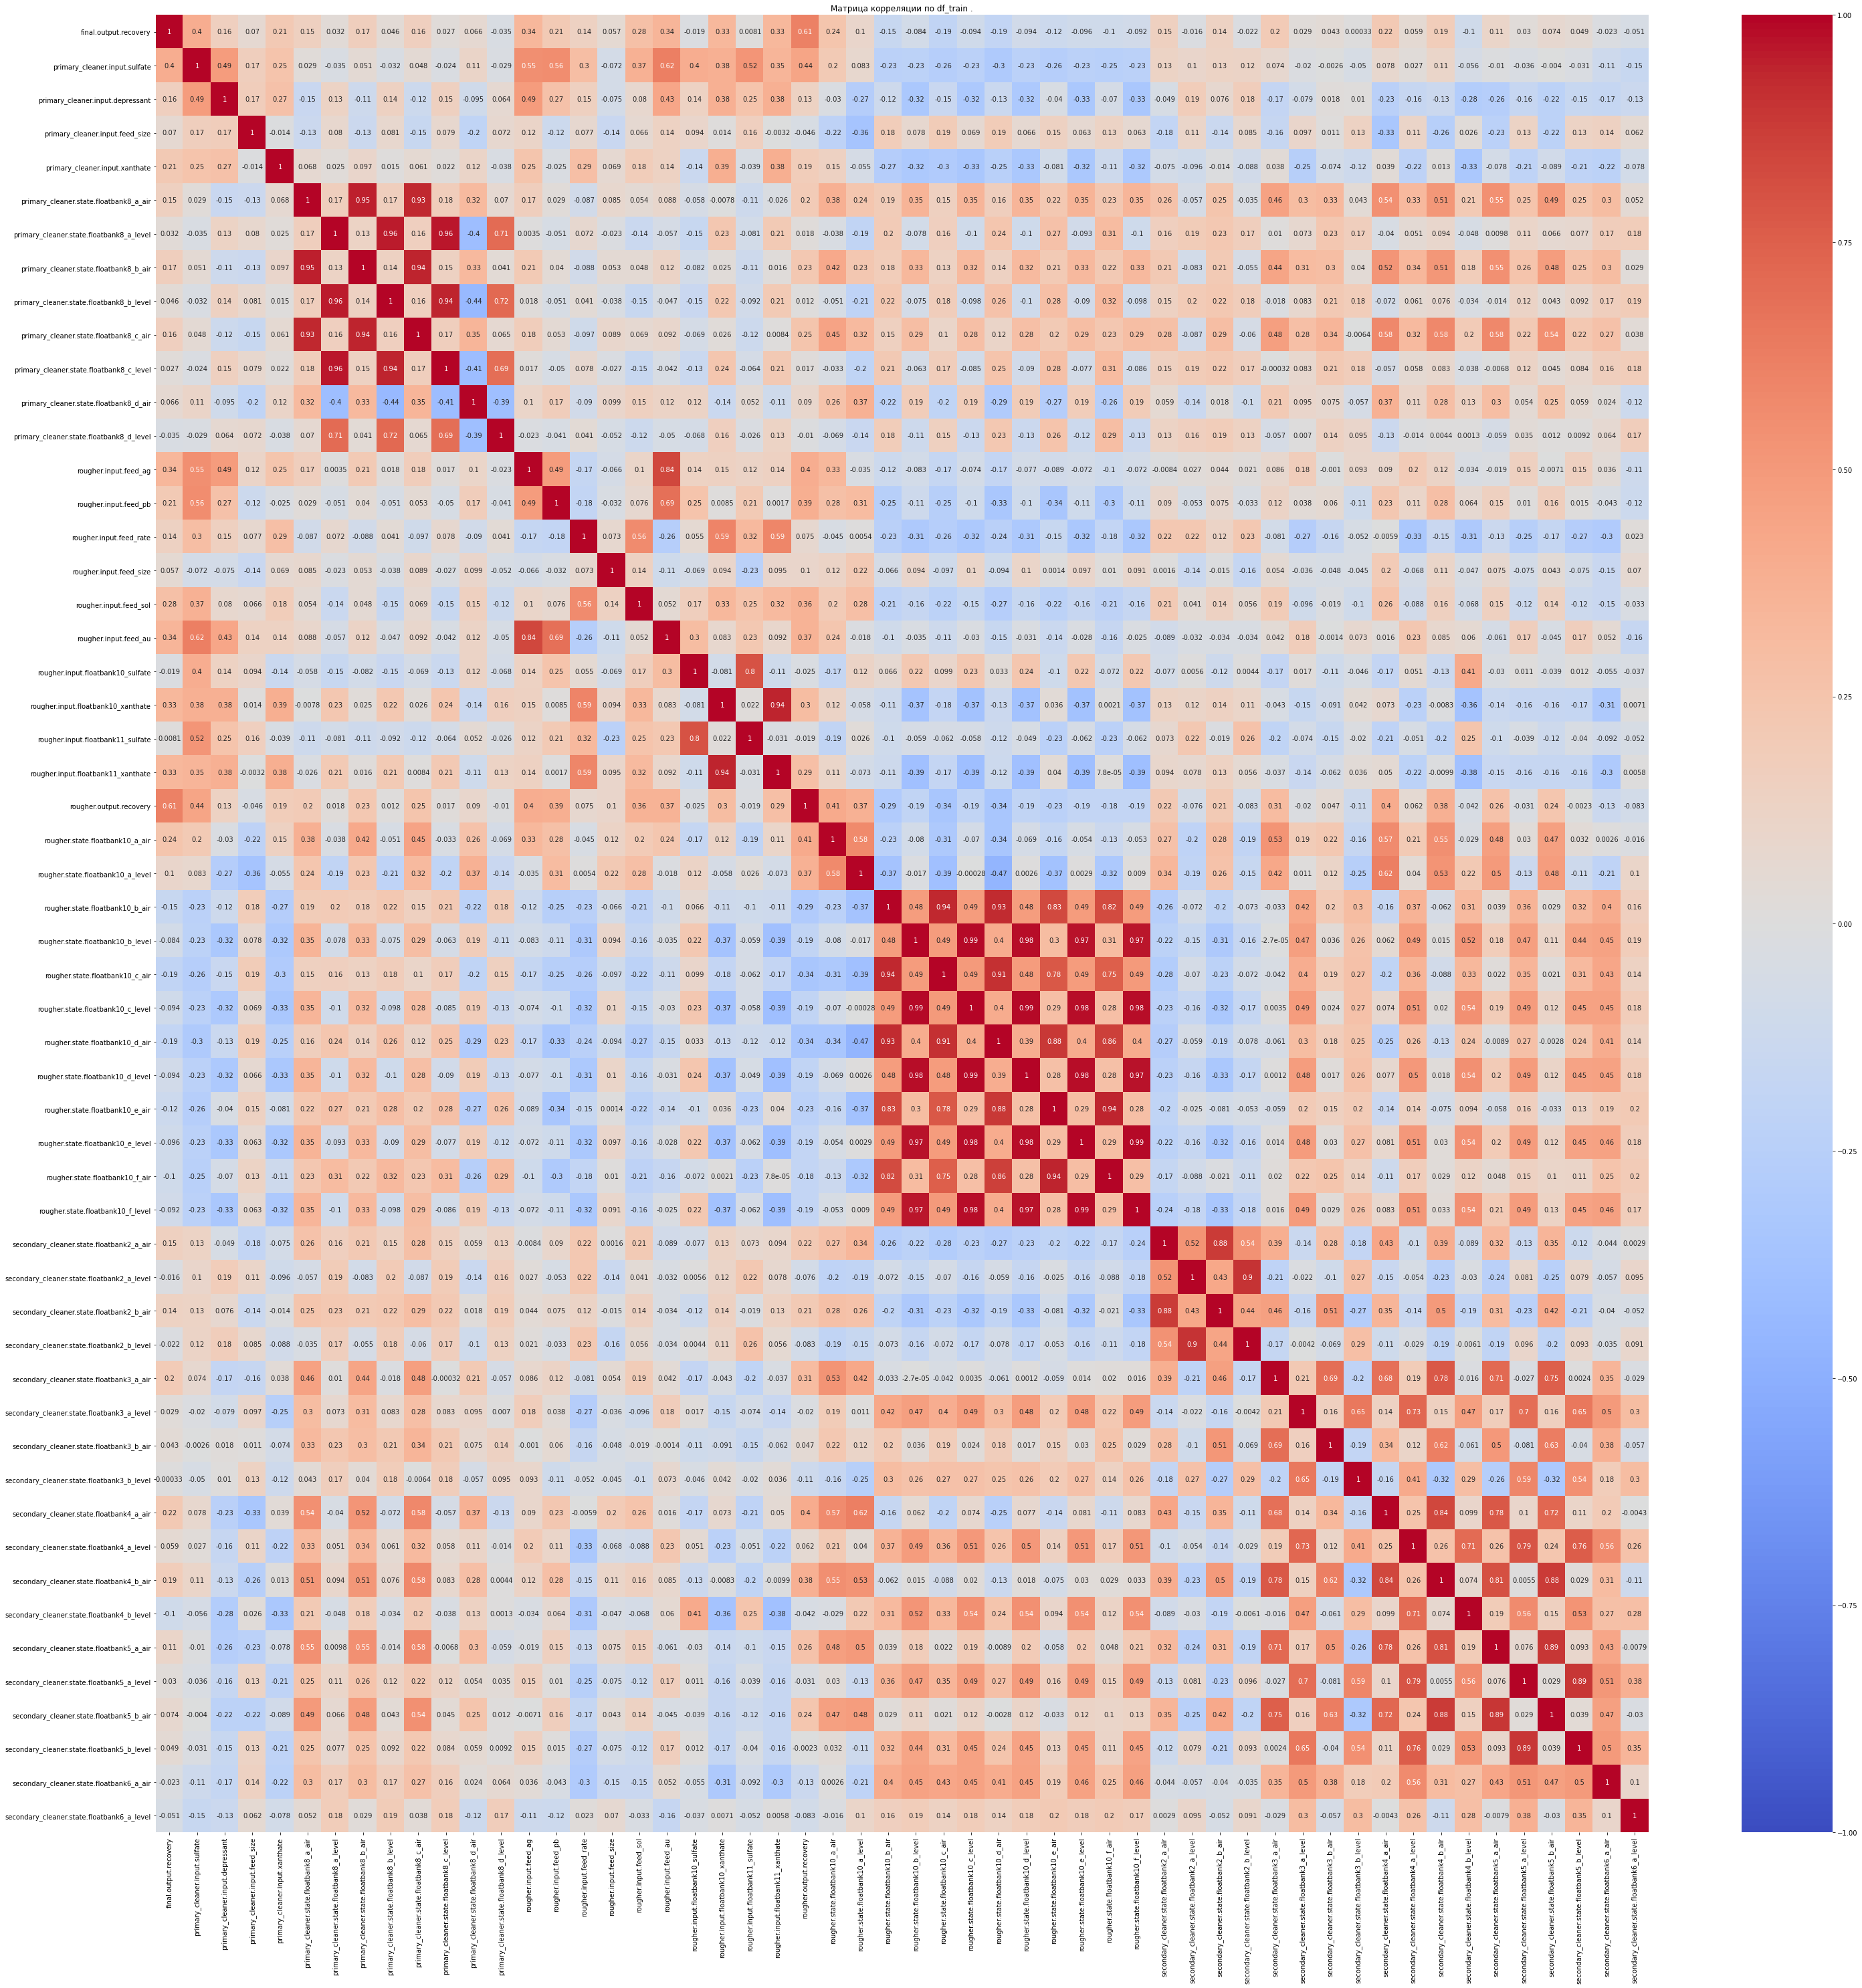

In [27]:
param = ['final.output.recovery', 'rougher.output.recovery', 'rougher.state.floatbank10_e_air', 'rougher.input.floatbank11_xanthate', 'secondary_cleaner.state.floatbank2_a_air', 'rougher.input.feed_size']
plt.figure(figsize = (50,50))
sns.heatmap(df_train.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm') #сделать отбор по колонкам param не получилось у меня почему-то но зато какая красивая корреляционная простыня 
plt.title('Матрица корреляции по df_train .')
plt.show()

После матрицы корреляции решила заполнить оставшиеся пропуски нулями, полагая что  столбцы в которых пропущены значения мало влияют на целевые признаки.

Нашла комментарий преподавателя подтверждающий это решение:

"Тимур Усатый [преподаватель]
пропущенные значения нужно заполнить, можно использовать метод fillna(method="ffill") или interpolate(). Первый заполняет пропуски предыдущими значениями, а второй интерполирует (находит значения между ближайшими двумя непустыми значениями )"

In [28]:
for data in (df_full, df_train, df_test):
    data.replace(0, np.nan, inplace=True)
    data.fillna(method='ffill', inplace=True)


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Верно!👍:\
</b> Верное решение по обработке пропусков, в признаках их не много. Все наблюдения представляют собой последовательные измерения, заполнить пропуски можно методами `pandas`: `ffill`/ `bfill`/ `interpolate` , это вполне уместно.\
Хочу посоветовать тебе статью, которая рассматривает разные способы обработки пропусков, выделяет их плюсы и минусы, думаю, тебе может быть интересно: https://loginom.ru/blog/missing   

In [29]:
for data in (df_full, df_train, df_test):
    print("Количество пропусков:", data.isna().sum().sum())

Количество пропусков: 0
Количество пропусков: 0
Количество пропусков: 0


Пожалуй  с пропусками покончено.

#### Поиск и обработка дубликатов 

In [30]:
print("Количество дубликатов в df_full:", df_full.duplicated().sum())
print("Количество дубликатов в df_train:", df_train.duplicated().sum())
print("Количество дубликатов в df_test:", df_test.duplicated().sum())

Количество дубликатов в df_full: 0
Количество дубликатов в df_train: 0
Количество дубликатов в df_test: 0


#### Категоризация данных 

смотря на данные и задачу кажется что категоризация  данных не требуется 

#### Преобразование типов  данных 

На данном этапе кажется что преобразование данных не нужно. 
* Все столбцы  с типом данных float64
* Столбы во всех трех выборках идентичны 
* Пропусков нет и дубликатов

Кажется что в целом можно переходить к исследовательскому анализу

In [31]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13781 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   final.output.recovery                       13781 non-null  float64
 1   primary_cleaner.input.sulfate               13781 non-null  float64
 2   primary_cleaner.input.depressant            13781 non-null  float64
 3   primary_cleaner.input.feed_size             13781 non-null  float64
 4   primary_cleaner.input.xanthate              13781 non-null  float64
 5   primary_cleaner.state.floatbank8_a_air      13781 non-null  float64
 6   primary_cleaner.state.floatbank8_a_level    13781 non-null  float64
 7   primary_cleaner.state.floatbank8_b_air      13781 non-null  float64
 8   primary_cleaner.state.floatbank8_b_level    13781 non-null  float64
 9   primary_cleaner.state.floatbank8_c_air      13781 non-nu

## Исследовательский анализ данных.

### Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы



На этом этапе я поняла, что самое простое было построить  график концентрации на столбцах которые я уже удалила , восстанавливать их и заново обрабатывать пропуски мне конечно не хотелось, поэтому  я выполнила задания по визуализации концентраций перед удалением колонок.

### Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. 
Если распределения сильно отличаются друг от друга, оценка модели будет неправильной



Видим что распределение значений на тестовой и обучающей выборке достаточно похожи

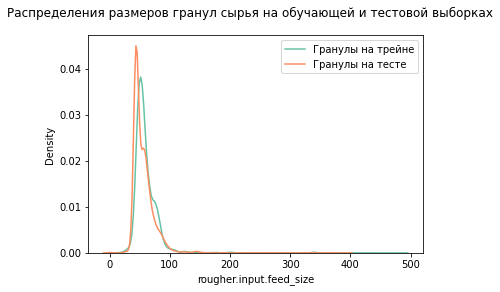

In [32]:
plt.suptitle('Распределения размеров гранул сырья на обучающей и тестовой выборках')
sns.kdeplot(data = df_train['rougher.input.feed_size'].dropna(), label='Гранулы на трейне')
sns.kdeplot(data = df_test['rougher.input.feed_size'].dropna(), label='Гранулы на тесте')

plt.legend()
plt.show()

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 

Распределения примерно одинаковы. Отлично, что использованы графики плотности, вместо гистограмм частотности)

### Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах


Этот этап так же выполнила до удаления столбцов 

### Обучите разные модели и оцените их качество кросс-валидацией.
Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы

## Построение и обучение модели 

### Напишите функцию для вычисления итоговой sMAPE

#### Метрика качества
Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).


In [33]:
def smape(y, y_pred):
    return (((abs(y - y_pred) * 2 * 100) / (abs(y) + abs(y_pred))).sum()) / len(y)

#### Подготовка к обучению 

Самой большой проблемой для меня на этапе выполнения проекта оказалась загвоздка с двумя таргетами (мульти-таргетность) как позднее я прочла  в ответе преподавателя. Поэтому попробуем сделать 1 модель с двумя таргетами.

Если ревьюеры как-то влияют на теорию, то очень бы хотелось чтобы этот момент там хоть как-то подсвечен. Хотя как и многие другие(

Нашла у преподавателя такой ответ на вопрос про два таргета:  " Тимур Усатый [преподаватель]

15:05
@trampa О, а это интересный момент. До этого проекта я сам бы использовал 2 разных модели, но как оказалось, в целом принципиального ограничения нет, кроме качества.

Учитывая кастомную метрику, в которой сводятся как раз 2 целевых параметра, мультитаргетность оказывается вполне работчим вариантом.

Вообще scikit-learn модели поддерживают мультитаргетность"


In [34]:
def total_smape(target, predicted):    
    target_rougher = target[:, 0]
    predicted_rougher = predicted[:, 0]
    target_final = target[:, 1]
    predicted_final = predicted[:, 1]
    total_smape = 0.25 * smape(target_rougher, predicted_rougher) + \
    0.75 * smape(target_final, predicted_final)
    return total_smape


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 

Функция правильная)

In [35]:
target_col = ['final.output.recovery', 'rougher.output.recovery'] #Целевые  столбцы 
RANDOM_ST = 12345

total_smape_scorer = make_scorer(total_smape, greater_is_better=False)

features = df_train.drop(target_col, axis=1)
target = np.array(df_train[target_col])

features_test = df_test.drop(target_col, axis=1)
target_test = np.array(df_test[target_col])

### Модель №1 - Дерево решений 

In [36]:
%%time

model_dt_best = None
smape_dt = 100
max_depth_best = 0

for d in range(2, 5):
    model = DecisionTreeRegressor(max_depth=d, random_state=RANDOM_ST)
    scores =  cross_val_score(model, features, target, scoring=total_smape_scorer, cv=5)
    result =  scores.mean()*(-1)
    if result < smape_dt:
        model_dt_best = model 
        total_smape_scores = cross_val_score(model, features, target, scoring=total_smape_scorer, cv=5)
        smape_dt = total_smape_scores.mean()*(-1)
        max_depth_best = d

print('sMAPE лучшей модели Дерево решений :', round(smape_dt, 2))
print('max_depth  лучшей модели Дерево решений :', max_depth_best)

sMAPE лучшей модели Дерево решений : 7.86
max_depth  лучшей модели Дерево решений : 3
CPU times: user 4.17 s, sys: 16.7 ms, total: 4.19 s
Wall time: 4.19 s


### Модель №2 - ElasticNet

In [37]:
%%time

model_elastic_best = None
smape_elastic = 100
alpha_best = 0
l1_ratio_best = 0

for a in range(1, 5):
    for r in range(1, 5):
        model = ElasticNet(random_state=RANDOM_ST, alpha=a, l1_ratio=r,)
        scores =  cross_val_score(model, features, target, scoring=total_smape_scorer, cv=5)
        result =  scores.mean()*(-1)
        if result < smape_elastic:
            model_elastic_best = model 
            total_smape_scores = cross_val_score(model, features, target, scoring=total_smape_scorer, cv=5)
            smape_elastic = total_smape_scores.mean()*(-1)
            alpha_best = a
            l1_ratio_best = r

print('sMAPE лучшей модели ElasticNet :', round(smape_elastic, 2))
print('alpha лучшей модели ElasticNet :', alpha_best)
print('l1_ratio лучшей модели ElasticNet :', l1_ratio_best)

sMAPE лучшей модели ElasticNet : 7.61
alpha лучшей модели ElasticNet : 4
l1_ratio лучшей модели ElasticNet : 1
CPU times: user 43.6 s, sys: 48.1 s, total: 1min 31s
Wall time: 1min 32s


### Модель №3 - Случайный лес

In [38]:
%%time

model_forest_best = None
smape_forest = 100
n_estimators_best = 0
max_depth_best = 0

for m in range(2, 5):
    for n in range(15, 20):
        model = RandomForestRegressor(random_state=RANDOM_ST, max_depth=m, n_estimators=n) 
        scores =  cross_val_score(model, features, target, scoring=total_smape_scorer, cv=5)
        result =  scores.mean()*(-1)
        if result < smape_forest:
            model_forest_best = model 
            total_smape_scores = cross_val_score(model, features, target, scoring=total_smape_scorer, cv=5)
            smape_forest = total_smape_scores.mean()*(-1)
            n_estimators_best = n
            max_depth_best = m

print('sMAPE лучшей модели Случайный лес:', round(smape_forest, 2))
print('n_estimators лучшей модели Случайный лес:', n_estimators_best)
print('max_depth лучшей модели Случайный лес:', max_depth_best)

sMAPE лучшей модели Случайный лес: 7.5
n_estimators лучшей модели Случайный лес: 19
max_depth лучшей модели Случайный лес: 3
CPU times: user 3min 26s, sys: 362 ms, total: 3min 26s
Wall time: 3min 27s


Лучшее = минимальное значение smape показал "случайный лес" с ним и поработаем на тестовой выборке 

### Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы

Проверим качество модели с помощью DummyRegressor

In [39]:
model_dmr = DummyRegressor(strategy="mean")
model_dmr.fit(features, target)
predictionsl_dmr = model_dmr.predict(features)
smape_dmr = total_smape(target, predictionsl_dmr).mean()

print('sMAPE на DummyRegressor: ', round(smape_dmr, 2))

sMAPE на DummyRegressor:  8.04


Если я правильно получила значение смапе на ДаммиРегрессор то можно сказать что каждая из полученных моделей показала себя не плохо, так как результат на моделях меньше чем на Дамми Регрессор

Лучшее значение показал Случайный лес (model_forest_best) на гиперпараметрах: n_estimators = 19 и  max_depth = 3

In [40]:
model_forest_best.fit(features, target)
predictionsl_mfb = model_forest_best.predict(features_test)
smape_best_test = total_smape(target_test, predictionsl_mfb).mean()

print('sMAPE лучшей модели на тестовой выборке ', round(smape_best_test, 2))


sMAPE лучшей модели на тестовой выборке  5.74


#### Dывод общий: 

1. В ходе выполнения проекта на тренировочной выборке обучены модели на трех алгоритмах: 
* Дерево  решений : лучший результат smape = 7,86 
* ЭластикНет : лучший результат smape = 7,61 
* Случайный лес: лучший результат smape = 7,50 ( выбран лучшей моделью так как искали минимальное значение) 

2. При проверки модели на адекватность алгоритомом  DummyRegressor, получено  значение smape = 8.04 
То, что все обученные модели показали результат лучше чем DummyRegressor, говорит о том что модели были обучены правильно

3. На тестовой выборке лучшая модель случайного леса (model_forest_best) показала резкльтат smape= 5,74. N

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>